In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score,\
                            recall_score, fbeta_score, precision_recall_curve

from hyperopt import hp
import hyperopt.pyll
from hyperopt.pyll import scope
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials

from datetime import datetime

import sys
sys.path.append('../../Pipeline')

from ml_utils import *


In [2]:
original_df = pd.read_csv('../../../data/cleandata/Info pluviometricas/Merged Data/repaired.csv', sep = ';')
original_df['Data_Hora'] = pd.to_datetime(original_df['Data_Hora'])
original_df['Date'] = original_df['Data_Hora'].dt.date

In [3]:
interest_cols = list({c.split('_')[0] for c in original_df.columns if '_error' in c})
interest_cols.remove('TemperaturaInterna')
interest_cols.remove('SensacaoTermica')

# Group Stations - Mean 

In [4]:
for c in interest_cols:
    original_df[c] = (original_df[c+'_0'] + original_df[c+'_1'] +
                      original_df[c+'_2'] + original_df[c+'_3'] + original_df[c+'_4'])/5 

## Plot data

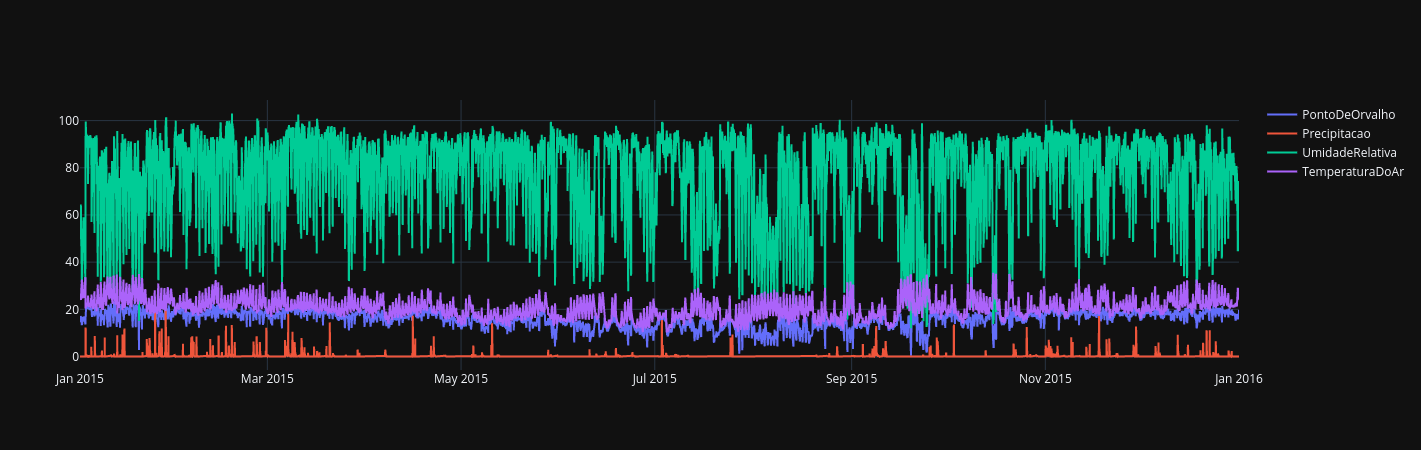

In [5]:
df_plot = original_df[original_df.Data_Hora.dt.year == 2015]

fig = go.Figure(layout=dict(template = 'plotly_dark'))

for col in ['PontoDeOrvalho', 'Precipitacao', 'UmidadeRelativa', 'TemperaturaDoAr']:    
    fig.add_trace(go.Scatter(
        x = df_plot['Data_Hora'],
        y = df_plot[col],
        name = col,
                            )
                 )
fig.show()

# Feature Engineering

In [6]:
interest_cols += ['Diff_Temp_POrvalho']
original_df['Diff_Temp_POrvalho'] = original_df['TemperaturaDoAr'] -  original_df['PontoDeOrvalho']

## Has Rain

In [7]:

has_rain_treshold = 10
precipitacao_sum = original_df.loc[:, ['Date', 'Precipitacao']].groupby('Date').sum()
precipitacao_sum.loc[:, 'Rain_Today'] = precipitacao_sum['Precipitacao'] > has_rain_treshold
precipitacao_sum.loc[:, 'Rain_Next_Day'] = precipitacao_sum.loc[:, 'Rain_Today'].shift(-1)
precipitacao_sum = precipitacao_sum.dropna()

precipitacao_sum.index = pd.to_datetime(precipitacao_sum.index, yearfirst=True)
precipitacao_sum.head()


Precipitacao  Rain_Today Rain_Next_Day
Date                                              
2011-01-01      1.520000       False          True
2011-01-02    139.120000        True          True
2011-01-03     65.875571        True          True
2011-01-04     62.360000        True          True
2011-01-05     11.960000        True          True

# Create Datewise DataFrame 

In [8]:
df = original_df[interest_cols + ['Date' , 'Data_Hora'] ]
df = df.set_index('Data_Hora')

In [9]:
unique_dates = df.index.round('D').unique()
df_date = pd.DataFrame(precipitacao_sum.index, columns = ['Date'])

In [10]:
df_date = df_date.merge(precipitacao_sum.loc[:, ['Rain_Today','Rain_Next_Day']], on = 'Date')
df_date = df_date.set_index('Date')

## Simple Metrics

In [11]:

sum_date = df[interest_cols + ['Date']].groupby('Date').sum()
sum_date.columns = [c + '_sum' for c in sum_date.columns]

median_date = df[interest_cols + ['Date']].groupby('Date').median()
median_date.columns = [c + '_median' for c in median_date.columns]

mean_date = df[interest_cols + ['Date']].groupby('Date').mean()
mean_date.columns = [c + '_mean' for c in mean_date.columns]

min_date = df[interest_cols + ['Date']].groupby('Date').min()
min_date.columns = [c + '_min' for c in min_date.columns]

max_date = df[interest_cols + ['Date']].groupby('Date').max()
max_date.columns = [c + '_max' for c in max_date.columns]


In [12]:
df_date = pd.concat([df_date, sum_date, mean_date, median_date, min_date, max_date], axis = 1)
df_date.head(2)

Rain_Today Rain_Next_Day  TemperaturaDoAr_sum  RadiacaoSolar_sum  \
Date                                                                          
2011-01-01      False          True          1992.746218       14057.252042   
2011-01-02       True          True          1878.630158        4910.817248   

            PressaoAtmosferica_sum  VelocidadeDoVento_sum  DirecaoDoVento_sum  \
Date                                                                            
2011-01-01            88258.915059             258.009259        13743.429635   
2011-01-02            88114.280457             134.788770        19644.838968   

            Precipitacao_sum  PontoDeOrvalho_sum  UmidadeRelativa_sum  ...  \
Date                                                                   ...   
2011-01-01              1.52         1681.052899          7917.578093  ...   
2011-01-02            139.12         1798.532057          9120.762358  ...   

            Diff_Temp_POrvalho_min  TemperaturaDoAr_max  RadiacaoSolar_max  \
Date                                                                         
2011-01-01                0.924580            24.150000         827.451509   
2011-01-02                0.509364            20.479328         355.424594   

            PressaoAtmosferica_max  VelocidadeDoVento_max  DirecaoDoVento_max  \
Date                                                                            
2011-01-01              921.612206               4.402470          188.236373   
2011-01-02              919.165367               2.773533          325.043926   

            Precipitacao_max  PontoDeOrvalho_max  UmidadeRelativa_max  \
Date                                                                    
2011-01-01              0.16           19.149212            93.863966   
2011-01-02              6.96           19.541844            96.573235   

            Diff_Temp_POrvalho_max  
Date                                
2011-01-01                7.164713  
2011-01-02                1.570889  

[2 rows x 47 columns]

## Time Metrics

In [13]:
hours = [3, 9, 15, 21 ]
for selected_hour in hours:

    selected_df = df.loc[(df.index.hour == selected_hour ) & (df.index.minute == 0 ), interest_cols ]
    selected_df.index = selected_df.index.round('D')
    selected_df.columns = [f'{c}_{selected_hour}H' for c in selected_df.columns]
    df_date = pd.concat([df_date, selected_df], axis = 1)

df_date = df_date.dropna(axis = 0)

In [14]:
df_date['Rain_Next_Day'] = df_date['Rain_Next_Day'].astype(int)
df_date['Rain_Today'] = df_date['Rain_Today'].astype(int)

In [15]:
df_date.head()

Rain_Today  Rain_Next_Day  TemperaturaDoAr_sum  RadiacaoSolar_sum  \
2011-01-02           1              1          1878.630158        4910.817248   
2011-01-03           1              1          1950.883170        7056.544026   
2011-01-04           1              1          2041.322756        9987.621929   
2011-01-05           1              1          2234.035760       19392.380825   
2011-01-06           1              1          2202.737789       18553.200000   

            PressaoAtmosferica_sum  VelocidadeDoVento_sum  DirecaoDoVento_sum  \
2011-01-02            88114.280457             134.788770        19644.838968   
2011-01-03            88108.819209             157.742309        12870.505605   
2011-01-04            88107.642739             194.357886        10139.030042   
2011-01-05            88412.377560             268.876633        17820.268917   
2011-01-06            88551.835972             258.574365        17090.583026   

            Precipitacao_sum  PontoDeOrvalho_sum  UmidadeRelativa_sum  ...  \
2011-01-02        139.120000         1798.532057          9120.762358  ...   
2011-01-03         65.875571         1822.832572          8869.706039  ...   
2011-01-04         62.360000         1898.676164          8777.487249  ...   
2011-01-05         11.960000         1860.973130          7674.131490  ...   
2011-01-06         42.720000         1836.051325          7756.348267  ...   

            Diff_Temp_POrvalho_15H  TemperaturaDoAr_21H  RadiacaoSolar_21H  \
2011-01-02                4.670777            19.663035                0.0   
2011-01-03                1.040536            19.824446                0.0   
2011-01-04                2.947215            20.073414                0.0   
2011-01-05                0.891206            20.812601                0.0   
2011-01-06                9.574831            22.097521                0.0   

            PressaoAtmosferica_21H  VelocidadeDoVento_21H  DirecaoDoVento_21H  \
2011-01-02              918.641275               4.402470          171.289637   
2011-01-03              917.859238               0.913005          325.043926   
2011-01-04              917.488114               1.120249          142.322584   
2011-01-05              918.365367               0.353594          222.640389   
2011-01-06              922.265174               2.129717          232.720686   

            Precipitacao_21H  PontoDeOrvalho_21H  UmidadeRelativa_21H  \
2011-01-02              0.00           18.117964            90.325700   
2011-01-03              0.04           18.922747            94.699543   
2011-01-04              0.08           19.426857            95.068082   
2011-01-05              0.00           19.842249            94.145937   
2011-01-06              0.80           19.908204            87.154319   

            Diff_Temp_POrvalho_21H  
2011-01-02                1.545071  
2011-01-03                0.901699  
2011-01-04                0.646558  
2011-01-05                0.970352  
2011-01-06                2.189317  

[5 rows x 83 columns]

## Seasonal Metrics

In [16]:

def get_season(Row):
    
    doy = Row.name.timetuple().tm_yday
    
    fall_start = datetime.strptime('2020-03-20', '%Y-%m-%d' ).timetuple().tm_yday
    summer_start = datetime.strptime('2020-06-20', '%Y-%m-%d' ).timetuple().tm_yday
    spring_start = datetime.strptime('2020-09-22', '%Y-%m-%d' ).timetuple().tm_yday
    spring_end = datetime.strptime('2020-12-21', '%Y-%m-%d' ).timetuple().tm_yday
    
    fall = range(fall_start, summer_start)
    summer = range(summer_start, spring_start)
    spring = range(spring_start, spring_end)
    
    if doy in fall:
        season = 1#'fall'
    elif doy in summer:
        season = 2#'winter'
    elif doy in spring:
        season = 3#'spring'
    else:
        season = 0#'summer' 
    
    return season

df_date['season'] =  df_date.apply(get_season, axis = 1)

In [17]:
seasonal_means = ['Precipitacao_mean']#, 'RadiacaoSolar_mean', 'TemperaturaDoAr_mean']

for s in seasonal_means:
    map_ = dict(df_date.groupby('season').mean()['Precipitacao_mean'])
    df_date[f'seasonalMean_{s}'] =  df_date['season'].map(map_)

df_date = df_date.drop(columns = ['season'])

In [18]:
df_date

Rain_Today  Rain_Next_Day  TemperaturaDoAr_sum  RadiacaoSolar_sum  \
2011-01-02           1              1          1878.630158        4910.817248   
2011-01-03           1              1          1950.883170        7056.544026   
2011-01-04           1              1          2041.322756        9987.621929   
2011-01-05           1              1          2234.035760       19392.380825   
2011-01-06           1              1          2202.737789       18553.200000   
...                ...            ...                  ...                ...   
2019-09-26           0              0          1539.114850        3544.781685   
2019-09-27           0              0          1553.601967       11317.168091   
2019-09-28           0              0          1380.568361        6145.049437   
2019-09-29           0              0          1606.344447       19990.001937   
2019-09-30           0              0          1724.567147       21716.193977   

            PressaoAtmosferica_sum  VelocidadeDoVento_sum  DirecaoDoVento_sum  \
2011-01-02            88114.280457             134.788770        19644.838968   
2011-01-03            88108.819209             157.742309        12870.505605   
2011-01-04            88107.642739             194.357886        10139.030042   
2011-01-05            88412.377560             268.876633        17820.268917   
2011-01-06            88551.835972             258.574365        17090.583026   
...                            ...                    ...                 ...   
2019-09-26            88946.446955             553.565228        12669.056286   
2019-09-27            89029.678298             853.018297        17315.810347   
2019-09-28            89128.721903             979.153862        10923.869830   
2019-09-29            88861.749472             875.135714        10673.114248   
2019-09-30            88820.732401             981.452869        10432.105804   

            Precipitacao_sum  PontoDeOrvalho_sum  UmidadeRelativa_sum  ...  \
2011-01-02        139.120000         1798.532057          9120.762358  ...   
2011-01-03         65.875571         1822.832572          8869.706039  ...   
2011-01-04         62.360000         1898.676164          8777.487249  ...   
2011-01-05         11.960000         1860.973130          7674.131490  ...   
2011-01-06         42.720000         1836.051325          7756.348267  ...   
...                      ...                 ...                  ...  ...   
2019-09-26          2.218529         1405.374210          8198.685306  ...   
2019-09-27          0.974406         1197.790306          7243.266297  ...   
2019-09-28          0.588248         1176.652721          7852.875367  ...   
2019-09-29          0.393223         1124.740529          6762.397147  ...   
2019-09-30          0.000000         1227.117110          6698.099047  ...   

            TemperaturaDoAr_21H  RadiacaoSolar_21H  PressaoAtmosferica_21H  \
2011-01-02            19.663035                0.0              918.641275   
2011-01-03            19.824446                0.0              917.859238   
2011-01-04            20.073414                0.0              917.488114   
2011-01-05            20.812601                0.0              918.365367   
2011-01-06            22.097521                0.0              922.265174   
...                         ...                ...                     ...   
2019-09-26            15.378209                0.0              927.563061   
2019-09-27            15.722432                0.0              927.312700   
2019-09-28            14.510203                0.0              929.289530   
2019-09-29            13.499027                0.0              928.488322   
2019-09-30            14.946810                0.0              926.089530   

            VelocidadeDoVento_21H  DirecaoDoVento_21H  Precipitacao_21H  \
2011-01-02               4.402470          171.289637          0.000000   
2011-01-03               0.913005         

# Reference Model

In [19]:
X, y = df_date.drop(columns = ['Rain_Next_Day']), df_date.Rain_Next_Day.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test.shape, X_train.shape

((1055, 83), (2139, 83))

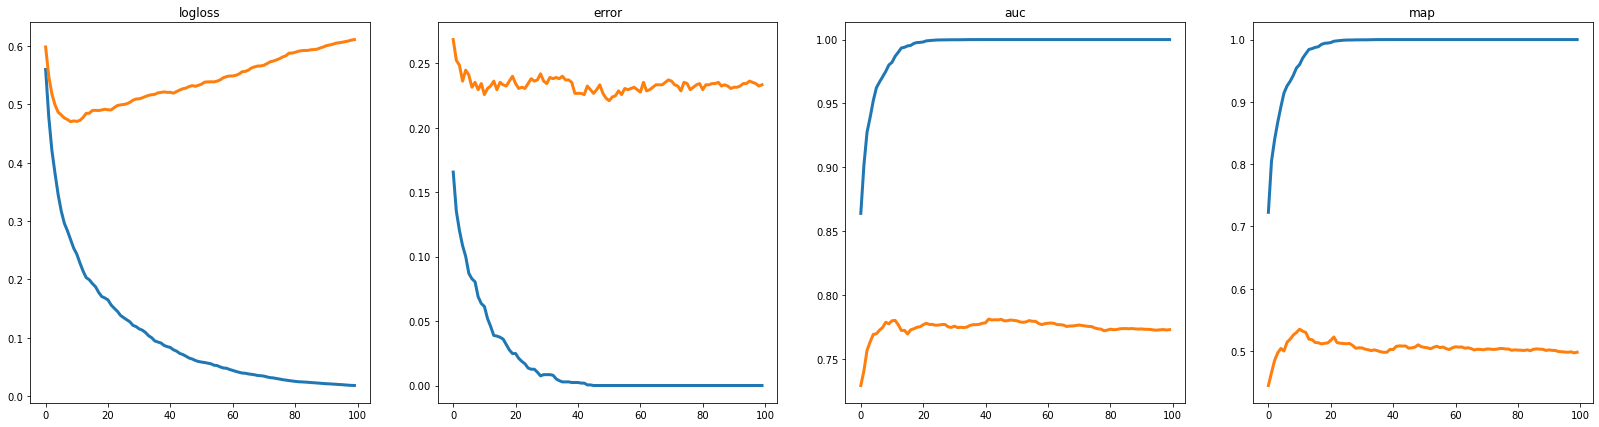

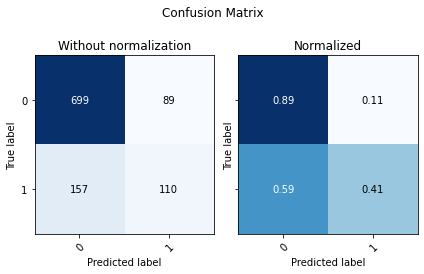

In [20]:
clf = xgb.XGBClassifier()#tree_method = 'gpu_hist')

eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train,  eval_metric=["logloss","error", "auc", "map"], eval_set=eval_set, verbose=False);

keys = clf.evals_result()['validation_0'].keys()

fig, ax = plt.subplots( 1, len(keys) ,figsize = (7*len(keys),7))
ax = ax.ravel()
for i, key in enumerate(keys):
    ax[i].set_title(key)
    ax[i].plot(clf.evals_result()['validation_0'][key], lw = 3)
    ax[i].plot(clf.evals_result()['validation_1'][key], lw = 3)
plt.show()

y_pred = clf.predict(X_test)
plot_confusion_matrix(y_test, y_pred, ['0', '1'])

In [21]:
df_date.Rain_Next_Day.value_counts()/df_date.shape[0]

0    0.749217
1    0.250783
Name: Rain_Next_Day, dtype: float64

In [22]:
f1_score(y_pred, y_test)

0.4721030042918455

# Feature Selection

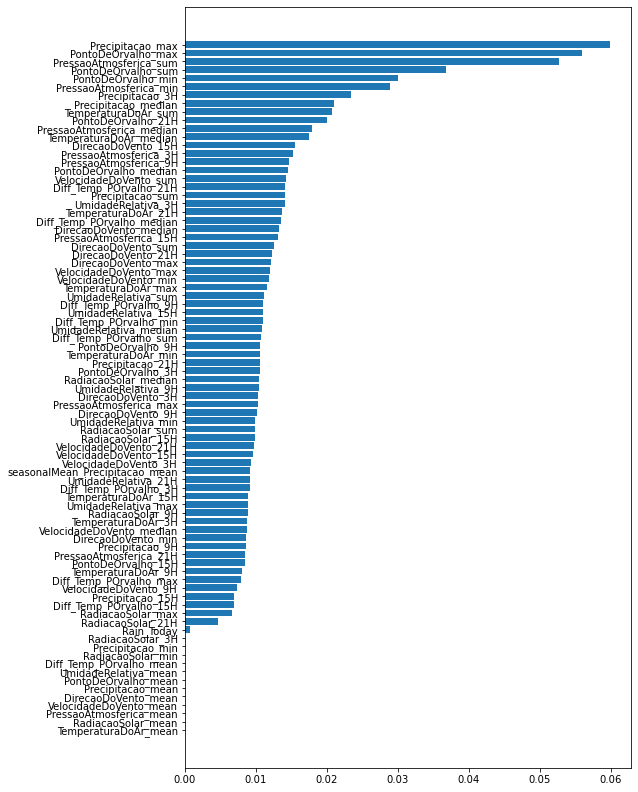

In [23]:
plt.figure(figsize = (8,14))

features_imp = dict(zip(X_train.columns, clf.feature_importances_))
features_imp = {k: v for k, v in sorted(features_imp.items(), key=lambda item: item[1])}

plt.barh(list(features_imp.keys()), features_imp.values())
plt.show()

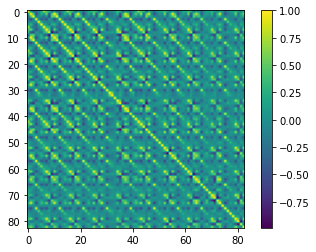

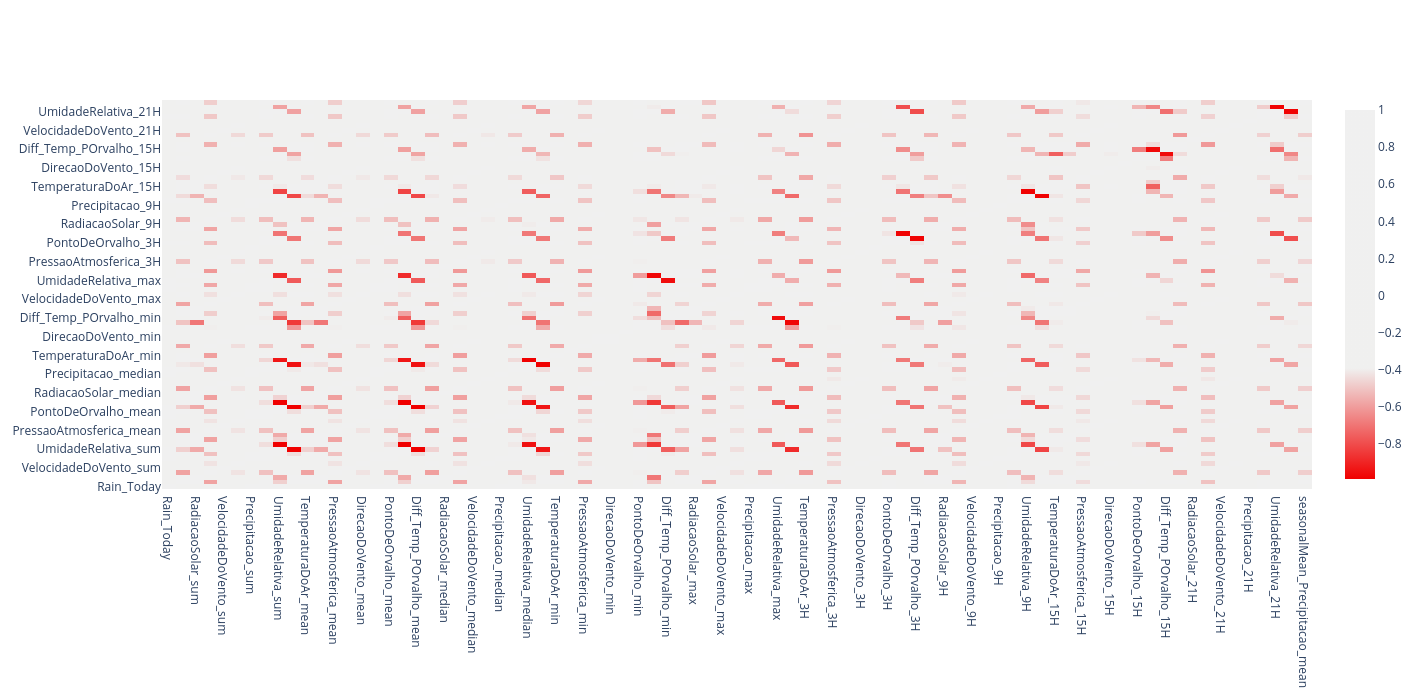

In [24]:

plt.imshow(X_train.corr())
plt.colorbar()
plt.show()

colorscale=[[0.0, "rgb(240, 0, 0)"],
            [0.3, "rgb(240, 240, 239)"],
            [1.0, 'rgb(240, 240, 240)']]

fig = go.Figure()

fig.add_trace(go.Heatmap( z = X_train.corr(),
                         x = X_train.columns,
                         y = X_train.columns, 
                         colorscale = colorscale))
fig.update_layout(width = 700, height = 700)
fig.show()

In [25]:
def remove_high_correlation(df, threshold):
    
    dataset = df.copy()
    
    remove_columns = []
    
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (np.abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    remove_columns.append(colname) # deleting the column from the dataset
                    
                    
    return remove_columns

In [26]:
remove_columns = remove_high_correlation(X_train, 0.7)
remove_columns += ['Precipitacao_min']

In [27]:
X_test_sel = X_test.drop(columns = remove_columns)
X_train_sel = X_train.drop(columns = remove_columns)

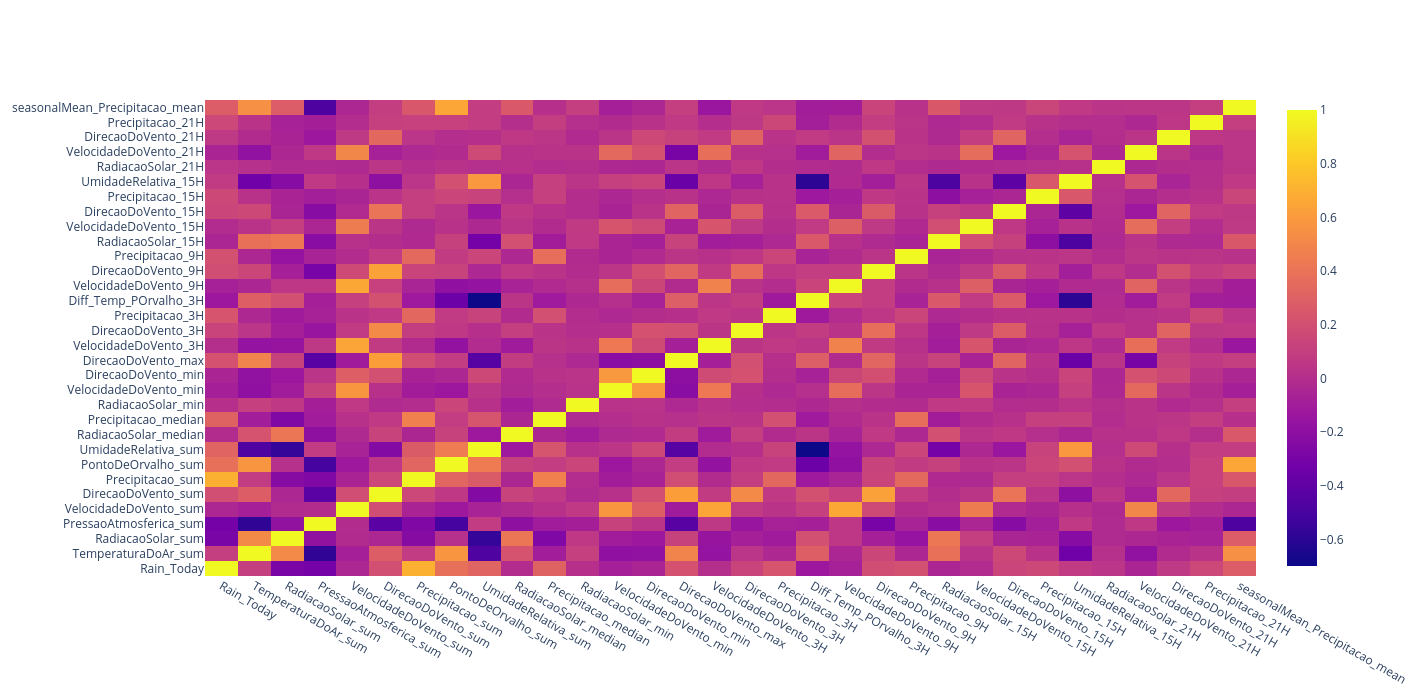

In [28]:
fig = go.Figure()
fig.add_trace(go.Heatmap( z = X_train_sel.corr(),
                         x = X_train_sel.columns,
                         y = X_train_sel.columns) )
fig.update_layout(width = 700, height = 700)
fig.show()

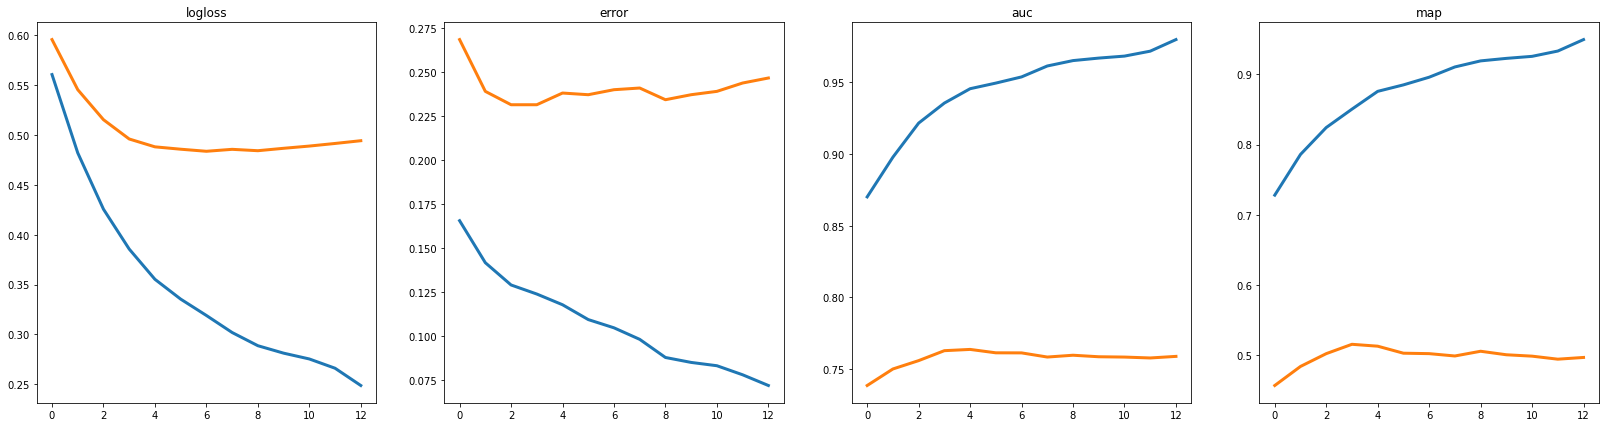

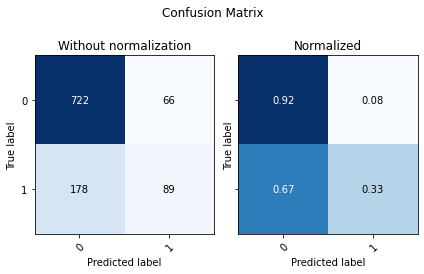

In [29]:
clf = xgb.XGBClassifier()#tree_method = 'gpu_hist')

eval_set = [(X_train_sel, y_train), (X_test_sel, y_test)]

clf.fit(X_train_sel, y_train,  eval_metric=["logloss","error", "auc", "map"],
        eval_set=eval_set, verbose=False, early_stopping_rounds=10,);

keys = clf.evals_result()['validation_0'].keys()

fig, ax = plt.subplots( 1, len(keys) ,figsize = (7*len(keys),7))
ax = ax.ravel()
for i, key in enumerate(keys):
    ax[i].set_title(key)
    ax[i].plot(clf.evals_result()['validation_0'][key], lw = 3)
    ax[i].plot(clf.evals_result()['validation_1'][key], lw = 3)
plt.show()

y_pred = clf.predict(X_test_sel)
plot_confusion_matrix(y_test, y_pred, ['0', '1'])

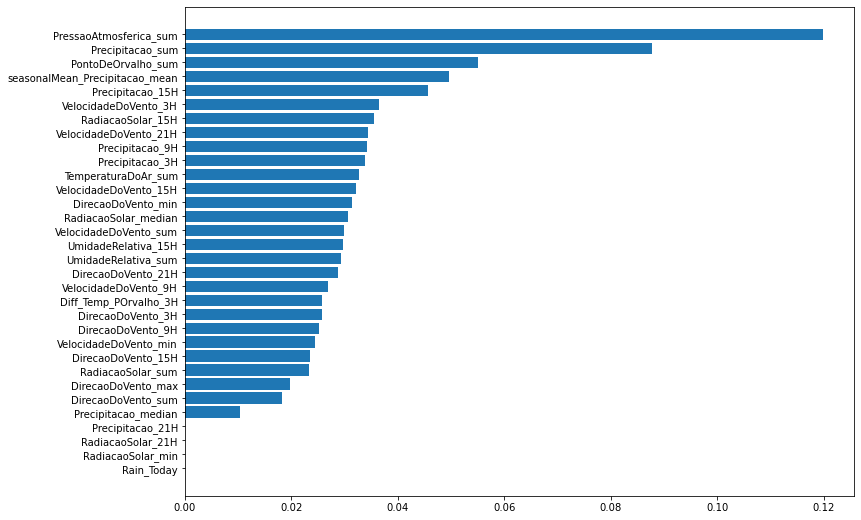

In [30]:
plt.figure(figsize = (12,9))

features_imp = dict(zip(X_train_sel.columns, clf.feature_importances_))
features_imp = {k: v for k, v in sorted(features_imp.items(), key=lambda item: item[1])}

plt.barh(list(features_imp.keys()), features_imp.values())
plt.show()

# Model Optimization

In [31]:

param_hyperopt = {
    'max_depth':scope.int(hp.quniform('max_depth', 5, 30, 1)),
    'n_estimators':scope.int(hp.quniform('n_estimators', 5, 1000, 1)),
    'min_child_weight':  scope.int(hp.quniform('min_child_weight', 1, 8, 1)),
    'reg_lambda':hp.uniform('reg_lambda', 0.01, 500.0),
    'reg_alpha':hp.uniform('reg_alpha', 0.01, 500.0),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.3, 1.0),
    'early_stopping_rounds':  scope.int(hp.quniform('early_stopping_rounds', 1, 20, 1)),
                 }

def cost_function(params):
    
    fit_parameters = {}
    fit_parameters['early_stopping_rounds'] = params.pop('early_stopping_rounds')

    clf = xgb.XGBClassifier(**params,
                            objective="binary:logistic",
                            random_state=42)

    clf.fit(X_train_sel, y_train, eval_set = eval_set, eval_metric=["logloss"], verbose = False,**fit_parameters)
    y_pred = clf.predict(X_test_sel)

    return {'loss':-fbeta_score(y_test, y_pred, beta=2),'status': STATUS_OK}

num_eval = 250
eval_set = [(X_train_sel, y_train), (X_test_sel, y_test)]

trials = Trials()
best_param = fmin(cost_function,
                     param_hyperopt,
                     algo=tpe.suggest,
                     max_evals=num_eval,
                     trials=trials,
                     rstate=np.random.RandomState(1))

100%|██████████| 250/250 [02:24<00:00,  1.73trial/s, best loss: -0.4119547657512116]


In [32]:
best_param['min_child_weight'] = int(best_param['min_child_weight'])
best_param['n_estimators'] = int(best_param['n_estimators'])
best_param['max_depth'] = int(best_param['max_depth'])
best_param['early_stopping_rounds'] = int(best_param['early_stopping_rounds'])
best_param

{'colsample_bytree': 0.39321911612446847,
 'early_stopping_rounds': 18,
 'max_depth': 16,
 'min_child_weight': 1,
 'n_estimators': 520,
 'reg_alpha': 0.12978238513939777,
 'reg_lambda': 129.86645579376275}

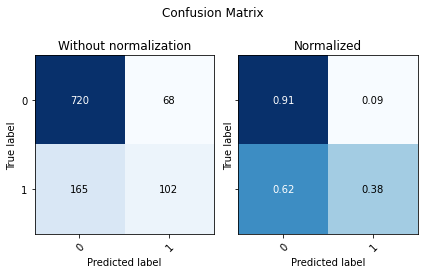

f1_score:  0.4668192219679634
Accuracy:  0.7791469194312797
Precision:  0.6
Recall:  0.38202247191011235


In [33]:
params = best_param.copy()

fit_parameters = {}
fit_parameters['early_stopping_rounds'] = params.pop('early_stopping_rounds')

clf = xgb.XGBClassifier(**params,
                        objective="binary:logistic",
                        random_state=42)

clf.fit(X_train_sel, y_train, eval_set = eval_set, eval_metric=["logloss"],
        verbose = False,**fit_parameters)
y_pred = clf.predict(X_test_sel)
y_pred_prob = clf.predict_proba(X_test_sel)

plot_confusion_matrix(y_test, y_pred, ['0','1'])
evaluate = (y_test, y_pred)
print('f1_score: ', f1_score(*evaluate))
print('Accuracy: ', accuracy_score(*evaluate))
print('Precision: ', precision_score(*evaluate))
print('Recall: ', recall_score(*evaluate))

In [34]:
plot_precision_recall(y_test, y_pred_prob[:,1])

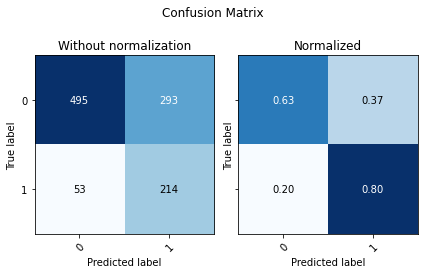

f1_score:  0.5529715762273901
Accuracy:  0.6720379146919432
Precision:  0.42209072978303747
Recall:  0.8014981273408239


In [35]:
desired_recall = 0.8

precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob[:,1])
y_pred_threshold = (y_pred_prob[:,1] > threshold[arg_nearest(recall, desired_recall)]).astype(int)

plot_confusion_matrix(y_test, y_pred_threshold, ['0','1'])
evaluate = (y_test, y_pred_threshold)
print('f1_score: ', f1_score(*evaluate))
print('Accuracy: ', accuracy_score(*evaluate))
print('Precision: ', precision_score(*evaluate))
print('Recall: ', recall_score(*evaluate))